## Case Study 4 DS7333
### Business Understanding
<font color='blue'> The goal of this case study is to analyze various finiancial and operating parameters of companies and predict if a company will eventually file for bankruptcy. These results should inturn help investors make right choices in where then should invest. </font>


In [ ]:
from scipy.io import arff
import pandas as pd
import numpy as np
import os
os.getcwd()
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, \
LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, accuracy_score, recall_score, \
f1_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import plot_tree
from sklearn import tree

## <font color='blue'> Exploring the available Data <br>
<font color='blue'> <b> We have data from 10173 companies collected over the period of 5 years. There are about 64 features describing the company and there is a target feature which tells us if the company went bankrupt or not. </b></font>

In [132]:
from os import listdir
from os.path import isfile, join
dir_files = [f for f in os.listdir(os.getcwd() + '/data') if os.path.isfile(join(os.getcwd() + '/data', f))]
dir_files

['2year.arff', '3year.arff', '5year.arff', '4year.arff', '1year.arff']

In [133]:
data_dict = {}
full_df = pd.DataFrame()

records = 0

for f in dir_files:
    temp_data = arff.loadarff(os.getcwd() + '/data/' +f)
    temp_df = pd.DataFrame(temp_data[0])
    print(temp_df.shape)
    data_dict.update({f:temp_df})
    full_df = pd.concat([full_df, temp_df])
    records += temp_df.shape[0]

print(records)

(10173, 65)
(10503, 65)
(5910, 65)
(9792, 65)
(7027, 65)
43405


In [134]:
full_df.shape

(43405, 65)

In [135]:
full_df.head(5)

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.202350,0.46500,0.240380,1.5171,-14.547,0.510690,0.25366,0.91816,1.15190,0.42695,...,0.13184,0.473950,0.86816,0.00024,8.5487,5.16550,107.740,3.38790,5.3440,b'0'
1,0.030073,0.59563,0.186680,1.3382,-37.859,-0.000319,0.04167,0.67890,0.32356,0.40437,...,0.12146,0.074369,0.87235,0.00000,1.5264,0.63305,622.660,0.58619,1.2381,b'0'
2,0.257860,0.29949,0.665190,3.2211,71.799,0.000000,0.31877,2.33200,1.67620,0.69841,...,0.16499,0.369210,0.81614,0.00000,4.3325,3.19850,65.215,5.59690,47.4660,b'0'
3,0.227160,0.67850,0.042784,1.0828,-88.212,0.000000,0.28505,0.47384,1.32410,0.32150,...,0.29358,0.706570,0.78617,0.48456,5.2309,5.06750,142.460,2.56210,3.0066,b'0'
4,0.085443,0.38039,0.359230,1.9444,21.731,0.187900,0.10823,1.37140,1.11260,0.52167,...,0.10124,0.163790,0.89876,0.00000,5.7035,4.00200,89.058,4.09840,5.9874,b'0'


<font color='blue'><b> As we see in the output of describe function below, each feature has different max and min ranges. 
The data will have to be standardized as before modeling </b> </font>

In [136]:
full_df.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
count,43397.000000,43397.000000,43397.000000,43271.000000,4.331600e+04,43397.000000,43397.000000,43311.000000,43396.000000,43397.000000,...,4.340400e+04,4.327800e+04,43398.000000,4.332100e+04,43398.000000,4.125300e+04,43303.000000,4.327800e+04,43271.000000,42593.000000
mean,0.035160,0.590212,0.114431,6.314702,-3.853466e+02,-0.056107,0.093478,12.640779,2.652166,0.626868,...,7.672188e+03,-2.621959e+01,-0.010510,3.002644e+01,1.333288,4.480858e+02,17.033202,1.502328e+03,9.343074,72.788592
std,2.994109,5.842748,5.439429,295.434425,6.124303e+04,7.201326,5.713075,505.894281,62.932732,14.670597,...,7.005310e+04,5.327862e+03,13.674072,5.334454e+03,122.104445,3.234560e+04,553.049406,1.392667e+05,124.177354,2369.339482
min,-463.890000,-430.870000,-479.960000,-0.403110,-1.190300e+07,-508.410000,-517.480000,-141.410000,-3.496000,-479.910000,...,-1.805200e+06,-1.108300e+06,-1667.300000,-1.986900e+02,-327.970000,-1.244000e+01,-12.656000,-2.336500e+06,-1.543200,-10677.000000
25%,0.003429,0.268980,0.021521,1.049500,-4.908000e+01,0.000000,0.005776,0.430275,1.018500,0.295470,...,2.755425e+01,9.348500e-03,0.014649,8.753200e-01,0.000000,5.545500e+00,4.510150,4.214400e+01,3.097650,2.176800
50%,0.049660,0.471900,0.196610,1.569800,-1.034500e+00,0.000000,0.059634,1.070400,1.195350,0.505970,...,1.088350e+03,5.294300e-02,0.119670,9.509600e-01,0.006366,9.791700e+00,6.636300,7.132600e+01,5.087600,4.282500
75%,0.129580,0.688320,0.403390,2.787450,5.063425e+01,0.089446,0.150880,2.615700,2.062500,0.709100,...,4.993325e+03,1.290975e-01,0.284605,9.926400e-01,0.236052,2.018100e+01,10.394500,1.172200e+02,8.598850,9.776200
max,94.280000,480.960000,28.336000,53433.000000,1.250100e+06,543.250000,649.230000,53432.000000,9742.300000,1099.500000,...,6.123700e+06,2.931500e+02,552.640000,1.108300e+06,23853.000000,4.818700e+06,108000.000000,2.501600e+07,23454.000000,294770.000000


In [137]:
full_df.columns.values

array(['Attr1', 'Attr2', 'Attr3', 'Attr4', 'Attr5', 'Attr6', 'Attr7',
       'Attr8', 'Attr9', 'Attr10', 'Attr11', 'Attr12', 'Attr13', 'Attr14',
       'Attr15', 'Attr16', 'Attr17', 'Attr18', 'Attr19', 'Attr20',
       'Attr21', 'Attr22', 'Attr23', 'Attr24', 'Attr25', 'Attr26',
       'Attr27', 'Attr28', 'Attr29', 'Attr30', 'Attr31', 'Attr32',
       'Attr33', 'Attr34', 'Attr35', 'Attr36', 'Attr37', 'Attr38',
       'Attr39', 'Attr40', 'Attr41', 'Attr42', 'Attr43', 'Attr44',
       'Attr45', 'Attr46', 'Attr47', 'Attr48', 'Attr49', 'Attr50',
       'Attr51', 'Attr52', 'Attr53', 'Attr54', 'Attr55', 'Attr56',
       'Attr57', 'Attr58', 'Attr59', 'Attr60', 'Attr61', 'Attr62',
       'Attr63', 'Attr64', 'class'], dtype=object)

<b> <font color='blue'> The target feature is a string which indicates 'no bankruptcy' if it is b'0' and bankruptcy if it is b'1'. Before 
modeling, we need to convert this to numerical values which is achieved below </font></b>

In [139]:
full_df['class'].unique()

array([b'0', b'1'], dtype=object)

In [140]:
full_df['class'].value_counts(normalize=False)

b'0'    41314
b'1'     2091
Name: class, dtype: int64

In [141]:
full_df['class'].value_counts(normalize=True)

b'0'    0.951826
b'1'    0.048174
Name: class, dtype: float64

From above, data is imbalanced.

In [142]:
classes = []

for index, row in full_df.iterrows():
    class_val = row['class']
    if class_val not in classes:
        classes.append(class_val)

In [143]:
classes

[b'0', b'1']

In [144]:
class_dict = {}

for index, i in enumerate(classes):
    class_dict.update({i:index})

class_dict

{b'0': 0, b'1': 1}

In [145]:
full_df['class'] = full_df['class'].map(class_dict)

In [146]:
full_df['class'].unique()

array([0, 1])

<font color='blue'><b> The view of full data frame and its feature data types is as below </b> </font>

In [147]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43405 entries, 0 to 7026
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Attr1   43397 non-null  float64
 1   Attr2   43397 non-null  float64
 2   Attr3   43397 non-null  float64
 3   Attr4   43271 non-null  float64
 4   Attr5   43316 non-null  float64
 5   Attr6   43397 non-null  float64
 6   Attr7   43397 non-null  float64
 7   Attr8   43311 non-null  float64
 8   Attr9   43396 non-null  float64
 9   Attr10  43397 non-null  float64
 10  Attr11  43361 non-null  float64
 11  Attr12  43271 non-null  float64
 12  Attr13  43278 non-null  float64
 13  Attr14  43397 non-null  float64
 14  Attr15  43369 non-null  float64
 15  Attr16  43310 non-null  float64
 16  Attr17  43311 non-null  float64
 17  Attr18  43397 non-null  float64
 18  Attr19  43277 non-null  float64
 19  Attr20  43278 non-null  float64
 20  Attr21  37551 non-null  float64
 21  Attr22  43397 non-null  float64
 22 

In [148]:
full_df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.202350,0.46500,0.240380,1.5171,-14.547,0.510690,0.25366,0.91816,1.15190,0.42695,...,0.13184,0.473950,0.86816,0.00024,8.5487,5.16550,107.740,3.38790,5.3440,0
1,0.030073,0.59563,0.186680,1.3382,-37.859,-0.000319,0.04167,0.67890,0.32356,0.40437,...,0.12146,0.074369,0.87235,0.00000,1.5264,0.63305,622.660,0.58619,1.2381,0
2,0.257860,0.29949,0.665190,3.2211,71.799,0.000000,0.31877,2.33200,1.67620,0.69841,...,0.16499,0.369210,0.81614,0.00000,4.3325,3.19850,65.215,5.59690,47.4660,0
3,0.227160,0.67850,0.042784,1.0828,-88.212,0.000000,0.28505,0.47384,1.32410,0.32150,...,0.29358,0.706570,0.78617,0.48456,5.2309,5.06750,142.460,2.56210,3.0066,0
4,0.085443,0.38039,0.359230,1.9444,21.731,0.187900,0.10823,1.37140,1.11260,0.52167,...,0.10124,0.163790,0.89876,0.00000,5.7035,4.00200,89.058,4.09840,5.9874,0



### Data Evaluation
<font color='blue'>
1. The dataset consists of 64 different attributes for over 10,000 different companies over a period of 5 years. <br>
2. We can see from the class variable only around 5% of the companies ended up filing bankruptcy.so, the dataset is imbalanced. Accuracy would not be the right metric since we have imbalanced data.<br>
3. In this scenario based on our problem that we are solving, the cost of False Negative would be high and Recall would be right metric to evaluate models. F-score which gives a balance between precision and recall can also be used as other metric. 
   </font>

## Random Forest Classifier

In [149]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = full_df.loc[:, full_df.columns != 'class'].values
y = full_df['class'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)


<font color='blue'> Use 33% of data for test. <br>
    Substitue missing values in all features by their respective means.
</font>

In [150]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imp_mean.fit(X_train)

X_train = imp_mean.transform(X_train)
X_test = imp_mean.transform(X_test)
cols = full_df.columns.values.tolist()
cols.remove('class')
X_train = pd.DataFrame(X_train, columns=cols)
X_test = pd.DataFrame(X_test, columns=cols)

#### Random Forest Model1 with default parameters

In [151]:
rf_clf1 = RandomForestClassifier(random_state = 0)
rf_clf1.fit(X_train, y_train)

rf_clf1.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [152]:
y_hat_rf_train1 = rf_clf1.predict(X_train)
print("Confusion Matrix \n",confusion_matrix(y_train, y_hat_rf_train1))
print("\n Classification Report \n",classification_report(y_train, y_hat_rf_train1, digits=6))

Confusion Matrix 
 [[27668     0]
 [    1  1412]]

 Classification Report 
               precision    recall  f1-score   support

           0   0.999964  1.000000  0.999982     27668
           1   1.000000  0.999292  0.999646      1413

    accuracy                       0.999966     29081
   macro avg   0.999982  0.999646  0.999814     29081
weighted avg   0.999966  0.999966  0.999966     29081



In [153]:
y_hat_rf_test1 = rf_clf1.predict(X_test)
print("Confusion Matrix \n",confusion_matrix(y_test, y_hat_rf_test1))
print("\n Classification Report \n",classification_report(y_test, y_hat_rf_test1, digits=6))

Confusion Matrix 
 [[13608    38]
 [  460   218]]

 Classification Report 
               precision    recall  f1-score   support

           0   0.967302  0.997215  0.982031     13646
           1   0.851562  0.321534  0.466809       678

    accuracy                       0.965233     14324
   macro avg   0.909432  0.659375  0.724420     14324
weighted avg   0.961823  0.965233  0.957644     14324



#### Feature Importance

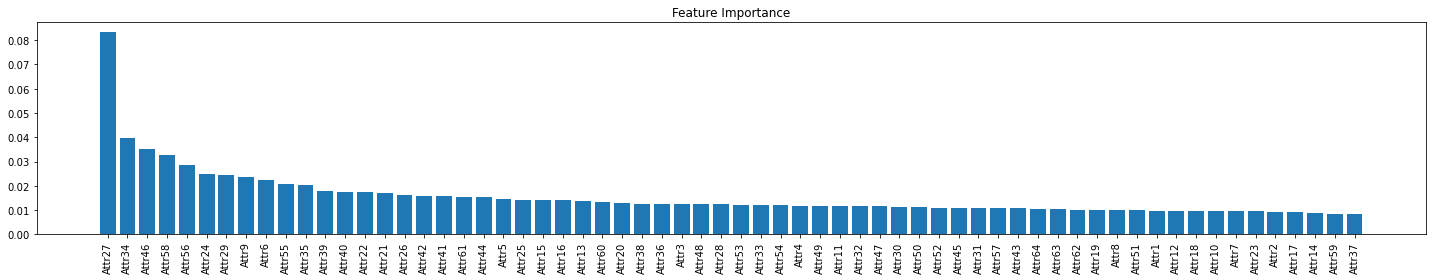

In [154]:

feature_importances = rf_clf1.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(20,4))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

<font color='blue'> The above bar chart shows feature importance as predicted by Random forest classifier. 
Attribute 'Attr27' is the most important one </font>

#### Top important features based on threshold

In [155]:
sfm = SelectFromModel(rf_clf1, threshold=0.02)

# Train the selector
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(random_state=0),
                threshold=0.02)

In [156]:
for feature_list_index in sfm.get_support(indices=True):
    print(cols[feature_list_index])

Attr6
Attr9
Attr24
Attr27
Attr29
Attr34
Attr35
Attr46
Attr55
Attr56
Attr58


In [157]:
imp_features = ['Attr6','Attr9','Attr24','Attr27','Attr29','Attr34','Attr35','Attr46','Attr55','Attr56']
X_train_imp = X_train[imp_features]
X_test_imp = X_test[imp_features]

#### Random Forest Model2 with parameters

In [158]:
rf_clf2 = RandomForestClassifier(n_estimators = 50, max_depth = 10, min_samples_split = 100, random_state = 2)
rf_clf2.fit(X_train, y_train)
y_hat_rf_train2 = rf_clf2.predict(X_train)
print("Confusion Matrix \n",confusion_matrix(y_train, y_hat_rf_train2))
print("\n Classification Report \n",classification_report(y_train, y_hat_rf_train2, digits=6))

Confusion Matrix 
 [[27668     0]
 [ 1111   302]]

 Classification Report 
               precision    recall  f1-score   support

           0   0.961395  1.000000  0.980318     27668
           1   1.000000  0.213730  0.352187      1413

    accuracy                       0.961796     29081
   macro avg   0.980698  0.606865  0.666252     29081
weighted avg   0.963271  0.961796  0.949798     29081



In [159]:
y_hat_rf_test2 = rf_clf2.predict(X_test)
print("Confusion Matrix \n",confusion_matrix(y_test, y_hat_rf_test2))
print("\n Classification Report \n",classification_report(y_test, y_hat_rf_test2, digits=6))

Confusion Matrix 
 [[13646     0]
 [  577   101]]

 Classification Report 
               precision    recall  f1-score   support

           0   0.959432  1.000000  0.979296     13646
           1   1.000000  0.148968  0.259307       678

    accuracy                       0.959718     14324
   macro avg   0.979716  0.574484  0.619301     14324
weighted avg   0.961352  0.959718  0.945217     14324



#### Random Forest Model3 with GridSearchCV

In [160]:
%%time
rf_clf3 = RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [25,50,100,200],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [10,15,20],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rf_clf3, param_grid=param_grid, cv= 2,verbose=1)
CV_rfc.fit(X_train, y_train)

Fitting 2 folds for each of 48 candidates, totalling 96 fits
CPU times: user 13min 22s, sys: 5.14 s, total: 13min 28s
Wall time: 13min 32s


GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [25, 50, 100, 200]},
             verbose=1)

In [161]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'auto',
 'n_estimators': 50}

#### Random Forest Model4 with best parameters from GridSearchCV

In [162]:
rf_clf4=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 50, max_depth=15, criterion='gini')
rf_clf4.fit(X_train, y_train)
y_hat_rf_train4 = rf_clf4.predict(X_train)
print("Confusion Matrix \n",confusion_matrix(y_train, y_hat_rf_train4))
print("\n Classification Report \n",classification_report(y_train, y_hat_rf_train4, digits=6))

Confusion Matrix 
 [[27668     0]
 [  403  1010]]

 Classification Report 
               precision    recall  f1-score   support

           0   0.985644  1.000000  0.992770     27668
           1   1.000000  0.714791  0.833677      1413

    accuracy                       0.986142     29081
   macro avg   0.992822  0.857396  0.913224     29081
weighted avg   0.986341  0.986142  0.985040     29081



In [163]:
y_hat_rf_test4 = rf_clf4.predict(X_test)
print("Confusion Matrix \n",confusion_matrix(y_test, y_hat_rf_test4))
print("\n Classification Report \n",classification_report(y_test, y_hat_rf_test4, digits=6))

Confusion Matrix 
 [[13632    14]
 [  472   206]]

 Classification Report 
               precision    recall  f1-score   support

           0   0.966534  0.998974  0.982486     13646
           1   0.936364  0.303835  0.458797       678

    accuracy                       0.966071     14324
   macro avg   0.951449  0.651404  0.720642     14324
weighted avg   0.965106  0.966071  0.957699     14324



#### Random Forest Model5 with important features & GridSearchCV

In [164]:
%%time
rf_clf5 = RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [25,50,100,200],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [10,15,20],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rf_clf5, param_grid=param_grid, cv= 2,verbose=1)
CV_rfc.fit(X_train_imp, y_train)
CV_rfc.best_params_

Fitting 2 folds for each of 48 candidates, totalling 96 fits
CPU times: user 4min 56s, sys: 1.51 s, total: 4min 58s
Wall time: 4min 59s


{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 50}

#### Random Forest Model6 with important features, GridSearchCV and best parameters.

In [165]:
rf_clf6=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 50, max_depth=10, criterion='entropy')
rf_clf6.fit(X_train_imp, y_train)
y_hat_rf_train6 = rf_clf6.predict(X_train_imp)
print("Confusion Matrix \n",confusion_matrix(y_train, y_hat_rf_train6))
print("\n Classification Report \n",classification_report(y_train, y_hat_rf_train6, digits=6))

Confusion Matrix 
 [[27668     0]
 [  844   569]]

 Classification Report 
               precision    recall  f1-score   support

           0   0.970398  1.000000  0.984977     27668
           1   1.000000  0.402689  0.574168      1413

    accuracy                       0.970978     29081
   macro avg   0.985199  0.701345  0.779572     29081
weighted avg   0.971837  0.970978  0.965016     29081



In [166]:
y_hat_rf_test6 = rf_clf6.predict(X_test_imp)
print("Confusion Matrix \n",confusion_matrix(y_test, y_hat_rf_test6))
print("\n Classification Report \n",classification_report(y_test, y_hat_rf_test6, digits=6))

Confusion Matrix 
 [[13640     6]
 [  459   219]]

 Classification Report 
               precision    recall  f1-score   support

           0   0.967444  0.999560  0.983240     13646
           1   0.973333  0.323009  0.485050       678

    accuracy                       0.967537     14324
   macro avg   0.970389  0.661285  0.734145     14324
weighted avg   0.967723  0.967537  0.959659     14324



#### Random Forest Model Performances

| Sno | Model                                                                     | Train/Test | Accuracy | Precision | Recall | F-Score |
|-----|---------------------------------------------------------------------------|------------|----------|-----------|--------|---------|
| 1   | Random Forest Default Parameters                                          | Train      | 0.99     | 1         | 0.99   | 0.99    |
|     |                                                                           | Test       | 0.96     | 0.85      | 0.32   | 0.46    |
| 2   | Random Forest with Parameters                                             | Train      | 0.96     | 1         | 0.21   | 0.35    |
|     |                                                                           | Test       | 0.95     | 1         | 0.14   | 0.25    |
| 3   | Random Forest with best parameters  from GridSearchCV                     | Train      | 0.98     | 1         | 0.71   | 0.83    |
|     |                                                                           | Test       | 0.96     | 0.93      | 0.30   | 0.45    |
| 4   | Random Forest with Important features & best parameters from GridSearchCV | Train      | 0.97     | 1         | 0.40   | 0.57    |
|     |                                                                           | Test       | 0.96     | 0.97      | 0.32   | 0.48    |

1. We have built 4-6 models on Random forest and also performed hypertuning with GridSearchCV.
2. Below are the top 10 attributes based on the Random Forest feature importance and threshold.
    * Attr27 - profit on operating activities / financial expenses 
    * Attr34 - operating expenses / total liabilities
    * Attr46 - current assets - inventory) / short-term liabilities
    * Attr58 - total costs /total sales
    * Attr56 - (sales - cost of products sold) / sales
    * Attr24 - gross profit (in 3 years) / total assets
    * Attr29 - logarithm of total assets
    * Attr9  - sales / total assets
    * Attr6  - retained earnings / total assets
    * Attr55 - working capital
    * Attr35 - profit on sales / total assets
3. Based on recall and f-score the model4 in the above table with important features and best parameters from gridsearchcv is best model. This model also generalizes well on the test dataset.

## XGBoost

#### XGBoost Model1 with defaults

In [167]:
xgb_clf1 = GradientBoostingClassifier(random_state=0).fit(X_train, y_train)
y_hat_xgb_train1 = xgb_clf1.predict(X_train)
print("Confusion Matrix \n",confusion_matrix(y_train, y_hat_xgb_train1))
print("\n Classification Report \n",classification_report(y_train, y_hat_xgb_train1, digits=6))

Confusion Matrix 
 [[27654    14]
 [  772   641]]

 Classification Report 
               precision    recall  f1-score   support

           0   0.972842  0.999494  0.985988     27668
           1   0.978626  0.453645  0.619923      1413

    accuracy                       0.972972     29081
   macro avg   0.975734  0.726569  0.802955     29081
weighted avg   0.973123  0.972972  0.968201     29081



In [168]:
y_hat_xgb_test1 = xgb_clf1.predict(X_test)
print("Confusion Matrix \n",confusion_matrix(y_test, y_hat_xgb_test1))
print("\n Classification Report \n",classification_report(y_test, y_hat_xgb_test1, digits=6))

Confusion Matrix 
 [[13623    23]
 [  413   265]]

 Classification Report 
               precision    recall  f1-score   support

           0   0.970576  0.998315  0.984250     13646
           1   0.920139  0.390855  0.548654       678

    accuracy                       0.969562     14324
   macro avg   0.945357  0.694585  0.766452     14324
weighted avg   0.968188  0.969562  0.963632     14324



#### XGBoost Model2 with hyperparmeters

In [169]:
xgb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_depth=2, random_state=0).fit(X_train, y_train)
y_hat_xgb_train2 = xgb_clf2.predict(X_train)
print("Confusion Matrix \n",confusion_matrix(y_train, y_hat_xgb_train2))
print("\n Classification Report \n",classification_report(y_train, y_hat_xgb_train2, digits=6))

Confusion Matrix 
 [[27613    55]
 [  864   549]]

 Classification Report 
               precision    recall  f1-score   support

           0   0.969660  0.998012  0.983632     27668
           1   0.908940  0.388535  0.544373      1413

    accuracy                       0.968399     29081
   macro avg   0.939300  0.693274  0.764002     29081
weighted avg   0.966709  0.968399  0.962289     29081



In [170]:
y_hat_xgb_test2 = xgb_clf2.predict(X_test)
print("Confusion Matrix \n",confusion_matrix(y_test, y_hat_xgb_test2))
print("\n Classification Report \n",classification_report(y_test, y_hat_xgb_test2, digits=6))

Confusion Matrix 
 [[13600    46]
 [  452   226]]

 Classification Report 
               precision    recall  f1-score   support

           0   0.967834  0.996629  0.982020     13646
           1   0.830882  0.333333  0.475789       678

    accuracy                       0.965233     14324
   macro avg   0.899358  0.664981  0.728905     14324
weighted avg   0.961351  0.965233  0.958059     14324



#### XGBoost Model3 with Important features

In [171]:
xgb_clf3 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_depth=2, random_state=0).fit(X_train_imp, y_train)
y_hat_xgb_train3 = xgb_clf3.predict(X_train_imp)
print("Confusion Matrix \n",confusion_matrix(y_train, y_hat_xgb_train3))
print("\n Classification Report \n",classification_report(y_train, y_hat_xgb_train3, digits=6))

Confusion Matrix 
 [[27601    67]
 [  947   466]]

 Classification Report 
               precision    recall  f1-score   support

           0   0.966828  0.997578  0.981962     27668
           1   0.874296  0.329795  0.478931      1413

    accuracy                       0.965132     29081
   macro avg   0.920562  0.663687  0.730447     29081
weighted avg   0.962332  0.965132  0.957521     29081



In [172]:
y_hat_xgb_test3 = xgb_clf3.predict(X_test_imp)
print("Confusion Matrix \n",confusion_matrix(y_test, y_hat_xgb_test3))
print("\n Classification Report \n",classification_report(y_test, y_hat_xgb_test3, digits=6))

Confusion Matrix 
 [[13599    47]
 [  478   200]]

 Classification Report 
               precision    recall  f1-score   support

           0   0.966044  0.996556  0.981063     13646
           1   0.809717  0.294985  0.432432       678

    accuracy                       0.963348     14324
   macro avg   0.887880  0.645771  0.706748     14324
weighted avg   0.958644  0.963348  0.955094     14324



#### XGBoost Model4 with Important features & GridSearchCV

In [173]:
parameters = {
    "learning_rate": [0.2,0.5,0.7],
    "min_samples_leaf": [0.1, 0.5],
    "max_depth":[3,8],
    "n_estimators":[10,30]
    }

xgb_clf4 = GridSearchCV(GradientBoostingClassifier(), parameters, cv=2, n_jobs=-1)
xgb_clf4.fit(X_train_imp, y_train)
xgb_clf4.best_params_

{'learning_rate': 0.7,
 'max_depth': 8,
 'min_samples_leaf': 0.1,
 'n_estimators': 30}

#### XGBoost Model4 with Important features & GridSearchCV & Best Parameters

In [174]:
xgb_clf5 = GradientBoostingClassifier(n_estimators=30, min_samples_leaf=0.1, learning_rate=0.7, max_depth=8, random_state=0).fit(X_train_imp, y_train)
y_hat_xgb_train5 = xgb_clf5.predict(X_train_imp)
print("Confusion Matrix \n",confusion_matrix(y_train, y_hat_xgb_train5))
print("\n Classification Report \n",classification_report(y_train, y_hat_xgb_train5, digits=6))

Confusion Matrix 
 [[27611    57]
 [  916   497]]

 Classification Report 
               precision    recall  f1-score   support

           0   0.967890  0.997940  0.982685     27668
           1   0.897112  0.351734  0.505338      1413

    accuracy                       0.966542     29081
   macro avg   0.932501  0.674837  0.744012     29081
weighted avg   0.964451  0.966542  0.959492     29081



In [175]:
y_hat_xgb_test5 = xgb_clf5.predict(X_test_imp)
print("Confusion Matrix \n",confusion_matrix(y_test, y_hat_xgb_test5))
print("\n Classification Report \n",classification_report(y_test, y_hat_xgb_test5, digits=6))

Confusion Matrix 
 [[13617    29]
 [  437   241]]

 Classification Report 
               precision    recall  f1-score   support

           0   0.968906  0.997875  0.983177     13646
           1   0.892593  0.355457  0.508439       678

    accuracy                       0.967467     14324
   macro avg   0.930749  0.676666  0.745808     14324
weighted avg   0.965294  0.967467  0.960706     14324



#### XGBoost Model Performances

| Sno | Model                                                                     | Train/Test | Accuracy | Precision | Recall | F-Score |
|-----|---------------------------------------------------------------------------|------------|----------|-----------|--------|---------|
| 1   | XGBoost Model Default Parameters                                          | Train      | 0.97     | 0.97      | 0.45   | 0.61    |
|     |                                                                           | Test       | 0.96     | 0.92      | 0.39   | 0.54    |
| 2   | XGBoost Model with Parameters                                             | Train      | 0.96     | 0.90      | 0.38   | 0.54    |
|     |                                                                           | Test       | 0.96     | 0.83      | 0.33   | 0.47    |
| 3   | XGBoost Model with Important features & best parameters from GridSearchCV | Train      | 0.96     | 0.89      | 0.35   | 0.50    |
|     |                                                                           | Test       | 0.96     | 0.89      | 0.35   | 0.50    |      

1. We have built 3-5 models based on XGBoost and also performed hypertuning with GridSearchCV.
2. From the above, XGBoost Model3 with Important features and hyperparmeters from GridSearhcv has best recall and the model generalizes with the test data as well.

#### Visualize Boosting Trees

In [176]:
# Couldnt get the Visualization using the XGBoost, the kernel is crashing.
# model = XGBClassifier()
# model.fit(X_train_imp, y_train)
# plot_tree(model)
# plt.show()

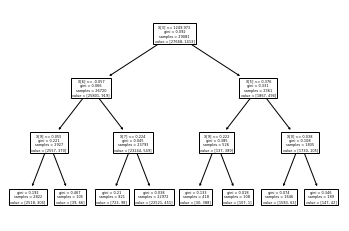

In [177]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth = 3,random_state = 0)
clf.fit(X_train_imp, y_train)
clf.predict(X_test_imp)
tree.plot_tree(clf);

## Conclusion

<font color='darkgreen'> <b> As seen above, the XGBoost model provides the best recall value . The suggestion is to deploy the XGBoost model to predict the bankruptcy of companies. There can be false positives produced by the model , so a second level of analysis may be required by domain experts to rule out the false positive cases. The investors portfolio health will be protected against bankruptcies by this model  </b> </font>